In [50]:
import sys
sys.path.append('./model')

import ss_fusion_cls
import torch
from torch  import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,cohen_kappa_score
from model import data_reader,split_data,utils
from sklearn import metrics, preprocessing
from mmengine.optim import build_optim_wrapper
from mmcv_custom import custom_layer_decay_optimizer_constructor,layer_decay_optimizer_constructor_vit
import random
import os
import scipy.io as sio
import spectral as spy
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
import h5py
import copy

In [51]:
from multiprocessing import shared_memory

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [53]:
def setup_seed(seed):
    random.seed(seed)  
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed =random.randint(1,9999)

In [54]:
setup_seed(seed)

In [55]:
class DataReader():
    def __init__(self):
        self.data_cube = None
        self.g_truth = None

    @property
    def cube(self):
        """
        origin data
        """
        return self.data_cube

    @property
    def truth(self):
        return self.g_truth

    @property
    def normal_cube(self):
        """
        normalization data: range(0, 1)
        """
        return (self.data_cube - np.min(self.data_cube)) / (np.max(self.data_cube) - np.min(self.data_cube))
    
class XionganRaw(DataReader):
    def __init__(self):
        super(XionganRaw, self).__init__()
        # file = h5py.File("/home/jinyao/HyperLargeModel/HyperLargeModel/data/Xiongan.mat") 
        # self.data_cube = file['data'][()].astype(np.float32)           
        # truth = sio.loadmat(r"/home/jinyao/HyperLargeModel/HyperLargeModel/data/Xiongan_GT.mat")
        # self.g_truth = truth["gt"].astype(np.float32)
        raw_data_package = sio.loadmat(r"data/Indian_pines_corrected.mat")
        self.data_cube = raw_data_package["data"].astype(np.float32)
        truth = sio.loadmat(r"data/Indian_pines_gt.mat")
        self.g_truth = truth["groundT"].astype(np.float32)

In [56]:
def load_data():
    data = XionganRaw().cube
    data_gt = XionganRaw().truth
    return data, data_gt


In [78]:
img_size = 33
patch_size =2
pca_components = 30
split_type = ['number', 'ratio'][0]
train_num =100
val_num =100
train_ratio = 0.05 
val_ratio = 0.005 
max_epoch = 300
batch_size = 64
learning_rate = 0.0000005  
dataset_name = 'Xiongan'

# path_weight = r"/home/jinyao/HyperLargeModel/HyperLargeModel/weights//"
# path_result = r"/home/jinyao/HyperLargeModel/HyperLargeModel/result//"
path_weight = r"weights//"
path_result = r"result//"
data, data_gt = load_data()
data_unprocessed = copy.deepcopy(data)
data_gt_unprocessed = copy.deepcopy(data_gt)
height, width, bands = data.shape
gt_reshape = np.reshape(data_gt, [-1])
class_num = np.max(data_gt)
class_num = class_num.astype(int)

In [79]:
data, pca = split_data.apply_PCA(data, num_components=pca_components)
data_processed = copy.deepcopy(data)
data_reshape = data.reshape(data.shape[0]*data.shape[1],data.shape[2])
data_index = np.arange(1, data_reshape.shape[0]+1, 1)
data_index=data_index.reshape(data.shape[0],data.shape[1],1)
zero = np.zeros((1,pca_components))
data_reshape = np.concatenate((zero, data_reshape), axis=0)
def data_extraction(data_reshape,x,img_size,pca_components):
    x=x.reshape(-1,img_size*img_size).to(torch.int)
    x = data_reshape[x,:]
    x=x.reshape(-1,img_size,img_size,pca_components)
    x = x.transpose(0, 3, 1, 2)
    x=  torch.FloatTensor(x)
    return x


In [59]:
train_index, val_index, test_index = split_data.split_data(gt_reshape, class_num, train_ratio, train_ratio, train_num, val_num, split_type)
data_all, data_label_all = split_data.create_patches(data_index, data_gt, window_size=img_size, remove_zero_labels = False)


In [60]:
train_index=train_index.astype(int)
val_index=val_index.astype(int)
test_index=test_index.astype(int)
height, width, bands = data.shape
gt_reshape = np.reshape(data_gt, [-1])
class_num = np.max(gt_reshape)
class_num = class_num.astype(int)

In [61]:
train_index0, val_index0, re_index = split_data.split_data(gt_reshape, 
            class_num, 0, 0, 0, 10,'ratio' )
re_index = np.sort(re_index)

train_index = train_index.reshape(-1,1)
val_index = val_index.reshape(-1,1)
test_index = test_index.reshape(-1,1)

train_label = data_label_all[train_index].reshape(-1,)
val_label = data_label_all[val_index].reshape(-1,)
test_label = data_label_all[test_index]

train = data_all[train_index,:,:,:]
val = data_all[val_index,:,:,:]
test = data_all[test_index,:,:,:]

split_data.data_info(train_label, val_label, test_label, np.max(data_label_all))

class 0 	 0 	 0 	 0
class 1 	 10 	 36 	 0
class 2 	 100 	 100 	 1228
class 3 	 100 	 100 	 630
class 4 	 100 	 100 	 37
class 5 	 100 	 100 	 283
class 6 	 100 	 100 	 530
class 7 	 10 	 18 	 0
class 8 	 100 	 100 	 278
class 9 	 10 	 10 	 0
class 10 	 100 	 100 	 772
class 11 	 100 	 100 	 2255
class 12 	 100 	 100 	 393
class 13 	 100 	 100 	 5
class 14 	 100 	 100 	 1065
class 15 	 100 	 100 	 186
class 16 	 10 	 83 	 0
total     	 1240 	 1347 	 7662


In [62]:
train = train.reshape(-1, img_size, img_size, 1)
val = val.reshape(-1, img_size, img_size, 1)
test = test.reshape(-1,img_size, img_size, 1)
print('before transpose: train shape: ', train.shape)
print('before transpose: test  shape: ', val.shape)
print('before transpose: test  shape: ', test.shape)

before transpose: train shape:  (1240, 33, 33, 1)
before transpose: test  shape:  (1347, 33, 33, 1)
before transpose: test  shape:  (7662, 33, 33, 1)


In [63]:
train_hi_gt= torch.zeros(train_label.size,class_num)
val_hi_gt= torch.zeros(val_label.size,class_num)
test_hi_gt= torch.zeros(test_label.size,class_num)


train_hi_gt = torch.LongTensor(train_hi_gt.numpy())
test_hi_gt = torch.LongTensor(test_hi_gt.numpy())
val_hi_gt = torch.LongTensor(val_hi_gt.numpy())

class TrainDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = train.shape[0]
        self.x_data = torch.FloatTensor(train)
        self.y_data = torch.LongTensor(train_label)
    def __getitem__(self, index):
      
        return self.x_data[index], self.y_data[index]

    def __len__(self):
      
        return self.len


""" Val dataset"""


class ValDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = val.shape[0]
        self.x_data = torch.FloatTensor(val)
        self.y_data = torch.LongTensor(val_label)

    def __getitem__(self, index):
       
        return self.x_data[index], self.y_data[index]

    def __len__(self):
      
        return self.len


""" Testing dataset"""


class TestDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = test.shape[0]
        self.x_data = torch.FloatTensor(test)
        self.y_data = torch.LongTensor(test_label)  
    def __getitem__(self, index):
       
        return self.x_data[index], self.y_data[index]

    def __len__(self):
       
        return self.len


trainset = TrainDS()
valset = ValDS()
testset = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [64]:
model = ss_fusion_cls.SSFusionFramework(
                img_size = img_size,
                in_channels = pca_components,
                patch_size=2,
                classes = class_num+1,
                model_size='base' #The optional values are 'base','large' and 'huge'
)
optim_wrapper = dict(
    optimizer=dict(
    type='AdamW', lr=6e-5, betas=(0.9, 0.999), weight_decay=0.05),
    constructor='LayerDecayOptimizerConstructor_ViT', 
    paramwise_cfg=dict(
        num_layers=12, 
        layer_decay_rate=0.9,
        )
        )
optimizer = build_optim_wrapper(model, optim_wrapper)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer.optimizer, 300, eta_min=0, last_epoch=-1)
criterion = nn.CrossEntropyLoss()
model.to(device)
count = 0
best_loss = 99999
train_losses = []
val_losses = []
model_params =model.state_dict()
spat_net = torch.load((r"../spat-base.pth"), map_location=torch.device('cpu'))
for k in list(spat_net['model'].keys()):
    if 'patch_embed.proj' in k:
        del spat_net['model'][k]
for k in list(spat_net['model'].keys()):
    if 'spat_map' in k:
        del spat_net['model'][k]
for k in list(spat_net['model'].keys()):
    if 'spat_output_maps' in k:
        del spat_net['model'][k]
for k in list(spat_net['model'].keys()):
    if 'pos_embed' in k:
        del spat_net['model'][k]
spat_weights = {}
prefix = 'spat_encoder.'
for key, value in spat_net['model'].items():
    new_key = prefix + key
    spat_weights[new_key] = value
per_net = torch.load((r"../spec-base.pth"), map_location=torch.device('cpu'))
model_params =model.state_dict()
for k in list(per_net['model'].keys()):
    if 'patch_embed.proj' in k:
        del per_net['model'][k]
    if 'spat_map' in k:
        del per_net['model'][k]
    if 'fpn1.0.weight' in k:
        del per_net['model'][k]
spec_weights = {}
prefix = 'spec_encoder.'
for key, value in per_net['model'].items():
    new_key = prefix + key
    spec_weights[new_key] = value
model_params =model.state_dict()
for k in list(spec_weights.keys()):
    if 'spec_encoder.patch_embed' in k:
        del spec_weights[k]
merged_params = {**spat_weights, **spec_weights}
same_parsms = {k: v for k, v in merged_params.items() if k in model_params.keys()}
model_params.update(same_parsms)
model.load_state_dict(model_params)

{'num_layers': 12, 'layer_decay_rate': 0.9}
Build LayerDecayOptimizerConstructor 0.900000 - 14
Param groups = {
  "layer_13_no_decay": {
    "param_names": [
      "spat_encoder.pos_embed",
      "spat_encoder.classifier.0.bias",
      "spat_encoder.classifier.1.bias",
      "spat_encoder.classifier.2.bias",
      "spat_encoder.cls.bias",
      "spat_encoder.classifier1.0.bias",
      "spat_encoder.classifier1.1.bias",
      "spat_encoder.classifier1.2.bias",
      "spat_encoder.patch_embed.proj.bias",
      "spat_encoder.blocks.0.norm1.weight",
      "spat_encoder.blocks.0.norm1.bias",
      "spat_encoder.blocks.0.attn.qkv.bias",
      "spat_encoder.blocks.0.attn.sampling_offsets.bias",
      "spat_encoder.blocks.0.attn.proj.bias",
      "spat_encoder.blocks.0.norm2.weight",
      "spat_encoder.blocks.0.norm2.bias",
      "spat_encoder.blocks.0.mlp.fc1.bias",
      "spat_encoder.blocks.0.mlp.fc2.bias",
      "spat_encoder.blocks.1.norm1.weight",
      "spat_encoder.blocks.1.norm1.bias

<All keys matched successfully>

In [65]:
# optim_wrapper = dict(
#     optimizer=dict(
#     type='AdamW', lr=6e-5, betas=(0.9, 0.999), weight_decay=0.05),
#     constructor='LayerDecayOptimizerConstructor_ViT', 
#     paramwise_cfg=dict(
#         num_layers=12, 
#         layer_decay_rate=0.9,
#         )
#         )
# optimizer = build_optim_wrapper(model, optim_wrapper)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer.optimizer, 300, eta_min=0, last_epoch=-1)
# criterion = nn.CrossEntropyLoss()
# model.to(device)
# count = 0
# best_loss = 99999
# train_losses = []
# val_losses = []
# for epoch in range(300+ 1):
#     correct = 0
#     total = 0
#     test_correct = 0
#     test_total = 0
#     _train_loss = 0
#     val_correct = 0
#     val_total = 0
#     _val_loss = 0
#     model.train()
#     for x, y in train_loader:
#         if torch.cuda.is_available():
#             x = data_extraction(data_reshape,x,img_size,pca_components)
#             x, y = x.to(device), y.to(device)
#         y_pred = model(x)
#         train_loss = criterion(y_pred, y)
#         optimizer.zero_grad()
#         train_loss.backward()
#         optimizer.step()
#         _train_loss += train_loss.item()

#         with torch.no_grad():
#             y_pred = torch.argmax(y_pred, dim=1)
#             correct = (y_pred == y).sum().item()
#             total = y.size(0)

#     train_losses.append(train_loss.cpu().detach().item())
    
#     if epoch % 10==0:
#         epoch_loss = _train_loss / len(train_loader.dataset)
#         epoch_accuracy = correct / total
#         if epoch_loss < best_loss:
#             best_loss = epoch_loss
#             torch.save(model.state_dict(), path_weight + "model.pth")
#             torch.save(optimizer.state_dict(), path_weight + 'optimizer.pth')
#             print('save model')

        
#         print('epoch', epoch,
#             'loss: ', round(epoch_loss, 5),
#             'accuracy: ', round(epoch_accuracy, 5),
#             )

In [66]:
count = 0
_test_loss = 0
model.load_state_dict(torch.load(path_weight + r"model.pth"))
model.eval()
with torch.no_grad():
    for x, y  in test_loader:
        if torch.cuda.is_available():
            x = data_extraction(data_reshape,x,img_size,pca_components)
            x, y = x.to(device), y.to(device)
        output = model(x)
        y_pred = torch.argmax(output, dim=1)
        test_correct += (y_pred == y).sum().item()
        test_total += y.size(0)
        if count == 0:
            y_pred_test =  y_pred.cpu().numpy()
            y_gt_test = y.cpu().numpy()
            count = 1
        else:
            y_pred_test = np.concatenate( (y_pred_test, y_pred.cpu().numpy()) )
            y_gt_test = np.concatenate( (y_gt_test, y.cpu().numpy()) )

testloss = _test_loss / len(test_loader.dataset)
OA_1 = metrics.accuracy_score(y_pred_test, y_gt_test)
confusion_matrix = metrics.confusion_matrix(y_pred_test, y_gt_test)
each_acc, average_acc = utils.aa_and_each_accuracy(confusion_matrix)
kappa = metrics.cohen_kappa_score(y_pred_test, y_gt_test)
OA_HybirdSN = test_correct / test_total
print("test loss={:.4f}\t test OA={:.4f}".format(testloss, OA_1))
print('kappa=',kappa)
print('each_acc=',each_acc)
print('average_acc=',average_acc)

c:\Users\Bjornolo\anaconda3\envs\AI\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\Bjornolo\anaconda3\envs\AI\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


test loss=0.0000	 test OA=0.9547
kappa= 0.946348391294638
each_acc= [0.         0.92548077 0.98145025 0.53623188 0.97569444 0.91130435
 0.98233216 0.         0.94344473 0.98231736 0.97058824 0.26315789
 0.98237477 0.96875    0.        ]
average_acc= 0.6948751226063149


ValueError: cannot reshape array of size 7662 into shape (149,149)

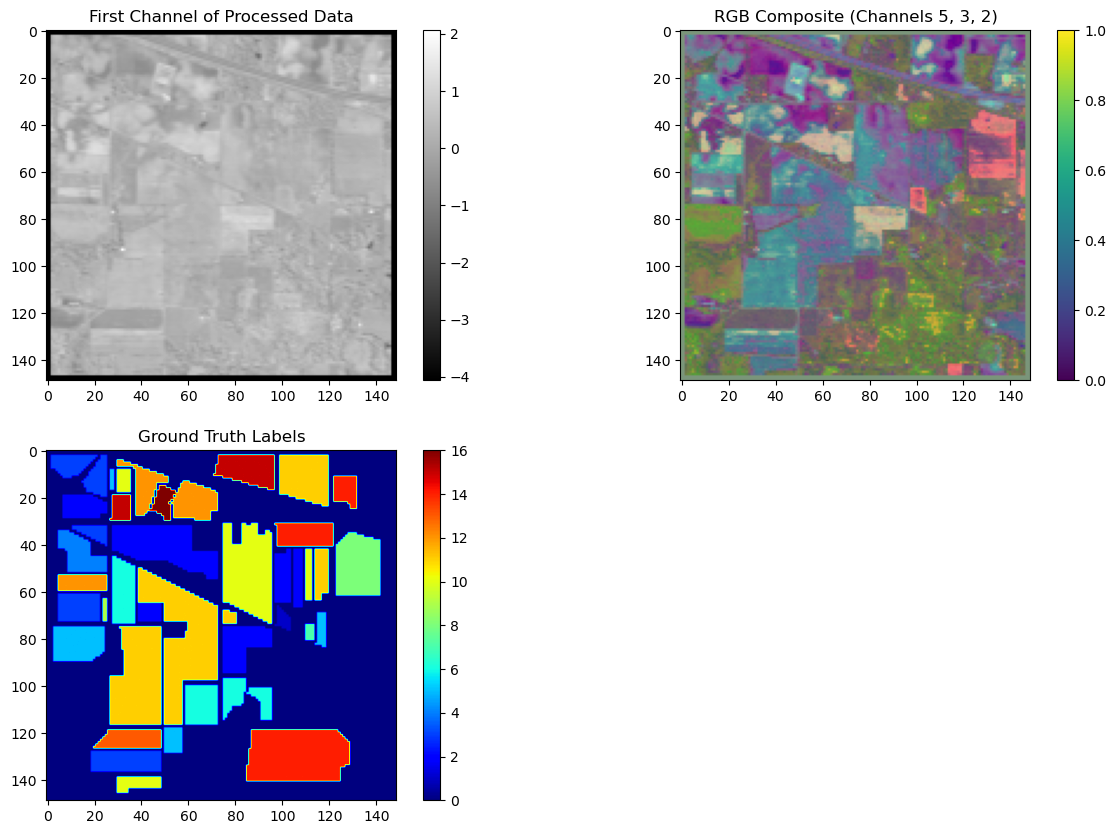

In [86]:
# Plot the first channel of the processed data
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(data_processed[:, :, 0], cmap='gray')
plt.title('First Channel of Processed Data')
plt.colorbar()

# Create an RGB composite using channels 5, 3, and 2
rgb_image = np.stack((data_processed[:, :, 4], data_processed[:, :, 2], data_processed[:, :, 1]), axis=-1)
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))  # Normalize to [0, 1]

plt.subplot(2, 2, 2)
plt.imshow(rgb_image)
plt.title('RGB Composite (Channels 5, 3, 2)')
plt.colorbar()

# Plot the ground truth labels
plt.subplot(2, 2, 3)
plt.imshow(data_gt, cmap='jet')
plt.title('Ground Truth Labels')
plt.colorbar()

# Plot the predicted labels
predicted_labels = y_pred_test.reshape(data_gt.shape[0], data_gt.shape[1])
plt.subplot(2, 2, 4)
plt.imshow(predicted_labels, cmap='jet')
plt.title('Predicted Labels')
plt.colorbar()

plt.show()